In [2]:
! pip install kaggle
from google.colab import drive
drive.mount('/content/drive')
! mkdir ~/.kaggle
! cp /content/drive/MyDrive/cs231n/assignments/finalproject/kaggle.json ~/.kaggle/kaggle.json
! chmod 600 ~/.kaggle/kaggle.json
! kaggle competitions download -c walmart-recruiting-store-sales-forecasting
! unzip walmart-recruiting-store-sales-forecasting.zip
!unzip features.csv.zip
!unzip train.csv.zip
!unzip test.csv.zip
!unzip sampleSubmission.csv.zip

Mounted at /content/drive
  0% 0.00/2.70M [00:00<?, ?B/s]
100% 2.70M/2.70M [00:00<00:00, 722MB/s]
Archive:  walmart-recruiting-store-sales-forecasting.zip
  inflating: features.csv.zip        
  inflating: sampleSubmission.csv.zip  
  inflating: stores.csv              
  inflating: test.csv.zip            
  inflating: train.csv.zip           
Archive:  features.csv.zip
  inflating: features.csv            
Archive:  train.csv.zip
  inflating: train.csv               
Archive:  test.csv.zip
  inflating: test.csv                
Archive:  sampleSubmission.csv.zip
  inflating: sampleSubmission.csv    


In [3]:
import pandas as pd

train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
features = pd.read_csv("features.csv")
stores = pd.read_csv("stores.csv")

In [4]:
print("Train:")
print(train.head())

print("\nTest:")
print(test.head())

print("\nFeatures:")
print(features.head())

print("\nStores:")
print(stores.head())
train.info()
features.info()

Train:
   Store  Dept        Date  Weekly_Sales  IsHoliday
0      1     1  2010-02-05      24924.50      False
1      1     1  2010-02-12      46039.49       True
2      1     1  2010-02-19      41595.55      False
3      1     1  2010-02-26      19403.54      False
4      1     1  2010-03-05      21827.90      False

Test:
   Store  Dept        Date  IsHoliday
0      1     1  2012-11-02      False
1      1     1  2012-11-09      False
2      1     1  2012-11-16      False
3      1     1  2012-11-23       True
4      1     1  2012-11-30      False

Features:
   Store        Date  Temperature  Fuel_Price  MarkDown1  MarkDown2  \
0      1  2010-02-05        42.31       2.572        NaN        NaN   
1      1  2010-02-12        38.51       2.548        NaN        NaN   
2      1  2010-02-19        39.93       2.514        NaN        NaN   
3      1  2010-02-26        46.63       2.561        NaN        NaN   
4      1  2010-03-05        46.50       2.625        NaN        NaN   

   MarkD

In [5]:
def missing_percent(df):
    return df.isna().mean().round(4) * 100

print("Features missing %:")
print(missing_percent(features))

Features missing %:
Store            0.00
Date             0.00
Temperature      0.00
Fuel_Price       0.00
MarkDown1       50.77
MarkDown2       64.33
MarkDown3       55.89
MarkDown4       57.70
MarkDown5       50.55
CPI              7.14
Unemployment     7.14
IsHoliday        0.00
dtype: float64


In [6]:
from sklearn.base import BaseEstimator, TransformerMixin
import pandas as pd
import numpy as np

class Preprocessor(BaseEstimator, TransformerMixin):
    def __init__(self, features_df, stores_df):
        self.features_df = features_df
        self.stores_df = stores_df
        self.cpi_median = None
        self.unemployment_median = None
        self.markdown_medians = {}

    def fit(self, X, y=None):
        # Ensure X is copied before merging to avoid modifying original data passed to fit
        df = pd.merge(X.copy(), self.features_df, on=["Store", "Date", "IsHoliday"], how="left")
        df = pd.merge(df, self.stores_df, on="Store", how="left")

        self.cpi_median = df["CPI"].median()
        self.unemployment_median = df["Unemployment"].median()

        markdown_cols = [f"MarkDown{i}" for i in range(1, 6)]
        for col in markdown_cols:
            self.markdown_medians[col] = df[col].median()

        return self

    def transform(self, X):
        df = X.copy() # Work on a copy

        df = pd.merge(df, self.features_df, on=["Store", "Date", "IsHoliday"], how="left")
        df = pd.merge(df, self.stores_df, on="Store", how="left")
        df["Date"] = pd.to_datetime(df["Date"])
        df["IsHoliday"] = df["IsHoliday"].astype(int)

        for col, median in self.markdown_medians.items():
            df[col] = df[col].fillna(median)

        df["CPI"] = df["CPI"].fillna(self.cpi_median)
        df["Unemployment"] = df["Unemployment"].fillna(self.unemployment_median)

        df["Type"] = df["Type"].map({"A": 0, "B": 1, "C": 2})

        # This part should only process Weekly_Sales if it exists and is not the target for prediction
        # (i.e., during training or for evaluation data where y is known)
        if "Weekly_Sales" in df.columns:
            df["Weekly_Sales"] = df["Weekly_Sales"].apply(lambda x: max(0, x))

        return df

class FeatureEngineer(BaseEstimator, TransformerMixin):
    def __init__(self, major_holiday_dates, holiday_dates_dict):
        self.major_holiday_dates = pd.to_datetime(major_holiday_dates)
        self.holiday_dates_dict = {k: pd.to_datetime(v) for k, v in holiday_dates_dict.items()}

        self._history_for_prediction = pd.DataFrame()
        self.max_lookback = max(max([1, 2, 3]), max([4, 12, 26]))

    def fit(self, X, y=None):
        # During fit, we capture the tail of the training data.
        X_sorted = X.sort_values(by=["Store", "Dept", "Date"]).copy()

        relevant_cols = ["Store", "Dept", "Date", "Weekly_Sales"]

        # For each Store-Dept combination, get the last 'max_lookback' rows
        self._history_for_prediction = X_sorted.groupby(["Store", "Dept"]).tail(self.max_lookback)[relevant_cols].copy()

        return self

    def transform(self, X):
        X_processed = X.copy()

        # Check if Weekly_Sales is present in the input X.
        # This determines if we are in "training/evaluation" mode or "prediction" mode.
        weekly_sales_present_in_input = "Weekly_Sales" in X_processed.columns

        combined_df = None # Initialize combined_df

        # If in prediction mode (Weekly_Sales is missing from input X) and we have history
        if not weekly_sales_present_in_input and not self._history_for_prediction.empty:
            stores_depts_in_X = X_processed[["Store", "Dept"]].drop_duplicates()
            relevant_history = self._history_for_prediction.merge(stores_depts_in_X, on=["Store", "Dept"], how="inner")

            # Ensure 'Weekly_Sales' column is present in X_processed if it's the target, but filled with NaN
            # This is to ensure concatenation works and we can identify the original rows later
            if 'Weekly_Sales' not in X_processed.columns:
                X_processed['Weekly_Sales'] = np.nan # Add as NaN for the prediction rows

            combined_df = pd.concat([relevant_history, X_processed], ignore_index=True)
            combined_df = combined_df.sort_values(by=["Store", "Dept", "Date"])

            # Temporarily treat 0s in Weekly_Sales (if any exist in history and represent missing) as NaN for MA/lag calculation
            # This is crucial for correct statistical calculation and avoid skewing means
            combined_df['Weekly_Sales'] = combined_df['Weekly_Sales'].replace(0, np.nan)

        else: # During training/validation, Weekly_Sales is present in X
            combined_df = X_processed.copy()
            combined_df = combined_df.sort_values(by=["Store", "Dept", "Date"])
            # Similar treatment for 0s in training data if they signify missing values for MA/lag
            combined_df['Weekly_Sales'] = combined_df['Weekly_Sales'].replace(0, np.nan)

        # Create time-based features
        combined_df["Year"] = combined_df["Date"].dt.year
        combined_df["Month"] = combined_df["Date"].dt.month
        combined_df["Week"] = combined_df["Date"].dt.isocalendar().week
        combined_df["Day"] = combined_df["Date"].dt.dayofweek

        # Calculate Lag and Moving Averages
        for lag in [1, 2, 3]:
            col = f"Weekly_Sales_Lag{lag}"
            combined_df[col] = combined_df.groupby(["Store", "Dept"])["Weekly_Sales"].shift(lag)
            combined_df[col] = combined_df[col].fillna(0) # Fill NaNs from shift with 0

        for window in [4, 12, 26]:
            col = f"Weekly_Sales_MA{window}"
            combined_df[col] = combined_df.groupby(["Store", "Dept"])["Weekly_Sales"].transform(
                lambda x: x.rolling(window=window, min_periods=1).mean()
            )
            combined_df[col] = combined_df[col].fillna(0) # Fill NaNs from rolling with 0

        # Holiday-related features
        def days_to_next_holiday(date):
            future = self.major_holiday_dates[self.major_holiday_dates > date]
            return (future.min() - date).days if len(future) else -1

        def days_since_last_holiday(date):
            past = self.major_holiday_dates[self.major_holiday_dates < date]
            return (date - past.max()).days if len(past) else -1

        combined_df["Days_To_Next_Holiday"] = combined_df["Date"].apply(days_to_next_holiday)
        combined_df["Days_Since_Last_Holiday"] = combined_df["Date"].apply(days_since_last_holiday)

        for holiday, dates in self.holiday_dates_dict.items():
            combined_df[holiday] = combined_df["Date"].isin(dates).astype(int)


        if not weekly_sales_present_in_input:
            final_df = combined_df.tail(len(X_processed)).drop(columns=["Weekly_Sales"], errors="ignore")
        else:
            final_df = combined_df.copy()
            final_df['Weekly_Sales'] = final_df['Weekly_Sales'].fillna(0) # Fill NaNs that weren't for lag/MA
            final_df["Weekly_Sales"] = final_df["Weekly_Sales"].apply(lambda x: max(0, x))

        return final_df


class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, drop_columns=None):
        self.drop_columns = drop_columns if drop_columns else []

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X.drop(columns=self.drop_columns, errors="ignore").copy()

In [7]:
from sklearn.pipeline import Pipeline

holiday_dates_dict = {
    "Super_Bowl": ["2010-02-12", "2011-02-11", "2012-02-10", "2013-02-08"],
    "Labor_Day": ["2010-09-10", "2011-09-09", "2012-09-07", "2013-09-06"],
    "Thanksgiving": ["2010-11-26", "2011-11-25", "2012-11-23", "2013-11-29"],
    "Christmas": ["2010-12-31", "2011-12-30", "2012-12-28", "2013-12-27"]
}

# Extract major holiday dates from train
major_holiday_dates = train[train["IsHoliday"] == True]["Date"].unique()

# Define pipeline
pipeline = Pipeline(steps=[
    ("preprocessing", Preprocessor(features, stores)),
    ("feature_engineering", FeatureEngineer(major_holiday_dates, holiday_dates_dict)),
    ("feature_selection", FeatureSelector(drop_columns=["Temperature", "Fuel_Price"]))
])

# Run pipeline
processed_train = pipeline.fit_transform(train)
processed_test = pipeline.transform(test)
processed_train.head()

/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


,Store,Dept,Date,Weekly_Sales,IsHoliday,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,...,Weekly_Sales_Lag3,Weekly_Sales_MA4,Weekly_Sales_MA12,Weekly_Sales_MA26,Days_To_Next_Holiday,Days_Since_Last_Holiday,Super_Bowl,Labor_Day,Thanksgiving,Christmas
0,1,1,2010-02-05,24924.50,0,5347.45,192.0,24.6,1481.31,3359.45,...,0.00,24924.500000,24924.500000,24924.500000,7,-1,0,0,0,0
1,1,1,2010-02-12,46039.49,1,5347.45,192.0,24.6,1481.31,3359.45,...,0.00,35481.995000,35481.995000,35481.995000,210,-1,1,0,0,0
2,1,1,2010-02-19,41595.55,0,5347.45,192.0,24.6,1481.31,3359.45,...,0.00,37519.846667,37519.846667,37519.846667,203,7,0,0,0,0
3,1,1,2010-02-26,19403.54,0,5347.45,192.0,24.6,1481.31,3359.45,...,24924.50,32990.770000,32990.770000,32990.770000,196,14,0,0,0,0
4,1,1,2010-03-05,21827.90,0,5347.45,192.0,24.6,1481.31,3359.45,...,46039.49,32216.620000,30758.196000,30758.196000,189,21,0,0,0,0


In [8]:
processed_train.shape

(421570, 30)

In [9]:
processed_test.shape

(115064, 29)

In [10]:
# Calculate mean and median weekly sales
mean_weekly_sales = processed_train['Weekly_Sales'].mean()
median_weekly_sales = processed_train['Weekly_Sales'].median()

print(f"Mean weekly sales: ${mean_weekly_sales:.2f}")
print(f"Median weekly sales: ${median_weekly_sales:.2f}")

# Compare holiday vs Non-Holiday Sales
holiday_sales = processed_train.groupby('IsHoliday')['Weekly_Sales'].agg(['mean', 'median', 'count'])

print("\nHoliday vs Non-Holiday Sales:")
print(holiday_sales)

# Top 5 departments by average sales
top_5_departments = processed_train.groupby('Dept')['Weekly_Sales'].mean().sort_values(ascending=False).head()

print("\nTop 5 departments by average sales:")
print(top_5_departments)

Mean weekly sales: $15981.47
Median weekly sales: $7612.03

Holiday vs Non-Holiday Sales:
                   mean   median   count
IsHoliday                               
0          15901.649652  7589.95  391909
1          17036.092349  7947.74   29661

Top 5 departments by average sales:
Dept
92    75204.870531
95    69824.423080
38    61090.619568
72    50567.019482
65    45441.706224
Name: Weekly_Sales, dtype: float64


In [11]:
# Ensure data is sorted by date before splitting
processed_train = processed_train.sort_values("Date").reset_index(drop=True)

# Determine the split sizes
train_size = int(len(processed_train) * 0.8)
val_size = int(len(processed_train) * 0.1)

# Determine the split points by index
train_split_date = processed_train.iloc[train_size]['Date']
val_split_date = processed_train.iloc[train_size + val_size]['Date']

# Convert 'Date' column to datetime if not already
processed_train['Date'] = pd.to_datetime(processed_train['Date'])

# Vectorized function to find next Friday
def find_closest_friday(date, df_dates):
    df_dates = pd.Series(df_dates)
    return df_dates[(df_dates >= date) & (df_dates.dt.weekday == 4)].min()

# Extract unique sorted dates
all_dates = pd.Series(processed_train['Date'].unique()).sort_values()

# Find adjusted split dates (closest Fridays)
train_split_date_friday = find_closest_friday(train_split_date, all_dates)
val_split_date_friday = find_closest_friday(val_split_date, all_dates)

print(f"Original train split date: {train_split_date}")
print(f"Original validation split date: {val_split_date}")

# Apply the time-based split using Friday boundaries
train_df = processed_train[processed_train['Date'] < train_split_date_friday]
val_df = processed_train[(processed_train['Date'] >= train_split_date_friday) & (processed_train['Date'] < val_split_date_friday)]
test_df = processed_train[processed_train['Date'] >= val_split_date_friday]

# Reset index
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

# Sanity checks for NaNs
assert not train_df.isnull().any().any(), "NaNs detected in train set"
assert not val_df.isnull().any().any(), "NaNs detected in val set"
assert not test_df.isnull().any().any(), "NaNs detected in test set"

# Print shapes
print("Training set shape:", train_df.shape)
print("Validation set shape:", val_df.shape)
print("Test set shape:", test_df.shape)

Original train split date: 2012-04-13 00:00:00
Original validation split date: 2012-07-20 00:00:00
Training set shape: (335761, 30)
Validation set shape: (41394, 30)
Test set shape: (44415, 30)


In [12]:
import wandb
wandb.login()

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


True

In [13]:
TARGET = "Weekly_Sales"
DROP_COLS = ["Date", TARGET]

# Features
X_train = train_df.drop(columns=DROP_COLS)
X_val = val_df.drop(columns=DROP_COLS)
X_test = test_df.drop(columns=DROP_COLS)

# Targets
y_train = train_df[TARGET]
y_val = val_df[TARGET]
y_test = test_df[TARGET]

In [14]:
def WMAE(y_true, y_pred, weights):
    return np.round(np.sum(weights * np.abs(y_true - y_pred)) / np.sum(weights), 5)

# Use 5 for holiday weeks, 1 otherwise
train_weights = np.where(train_df["IsHoliday"] == 1, 5, 1)
val_weights = np.where(val_df["IsHoliday"] == 1, 5, 1)
test_weights = np.where(test_df["IsHoliday"] == 1, 5, 1)

Starting grid search with 24 combinations...

[1/24] Training with lr=0.01, leaves=31, subsample=0.8, colsample=0.8
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l1: 1099.62	valid_0's l2: 4.73639e+06
→ Val WMAE: 1099.61852, Test WMAE: 1094.45597

[2/24] Training with lr=0.01, leaves=31, subsample=0.8, colsample=1.0
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[559]	valid_0's l1: 1128.78	valid_0's l2: 5.00677e+06
→ Val WMAE: 1128.77504, Test WMAE: 1129.37312

[3/24] Training with lr=0.01, leaves=31, subsample=1.0, colsample=0.8
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l1: 1099.62	valid_0's l2: 4.73639e+06
→ Val WMAE: 1099.61852, Test WMAE: 1094.45597

[4/24] Training with lr=0.01, leaves=31, subsample=1.0, colsample=1.0
Training until validation scores don't improve for 50 r

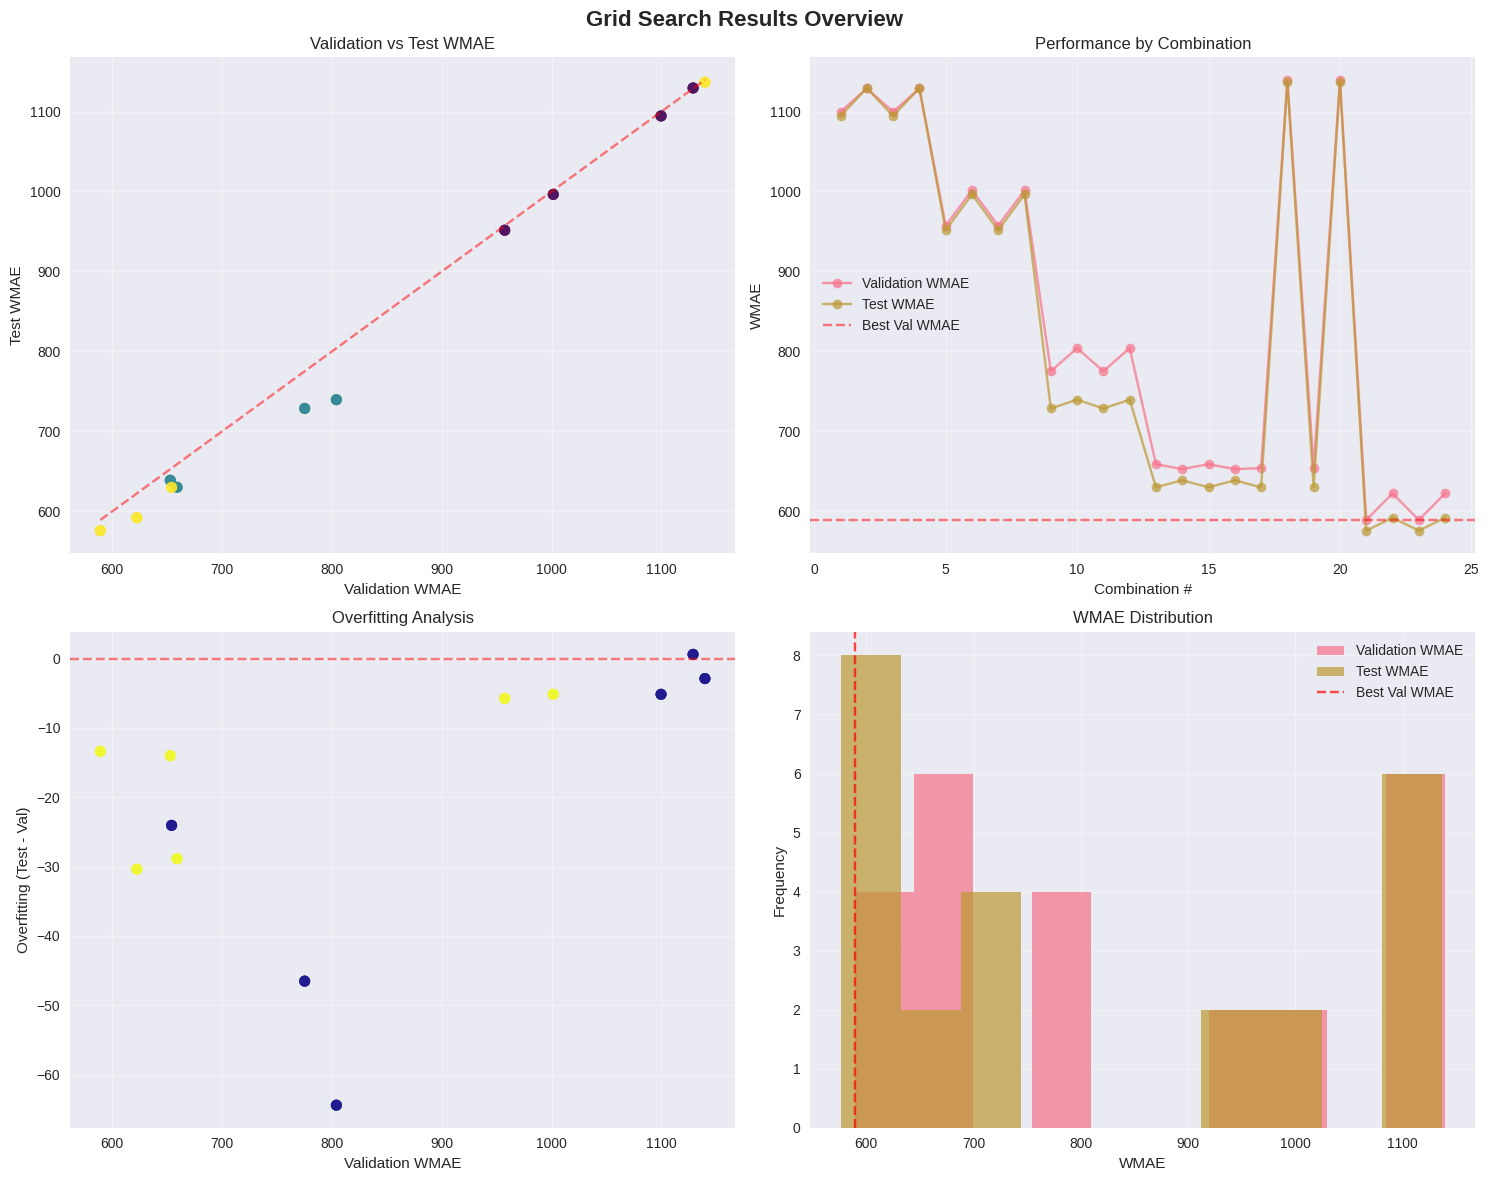

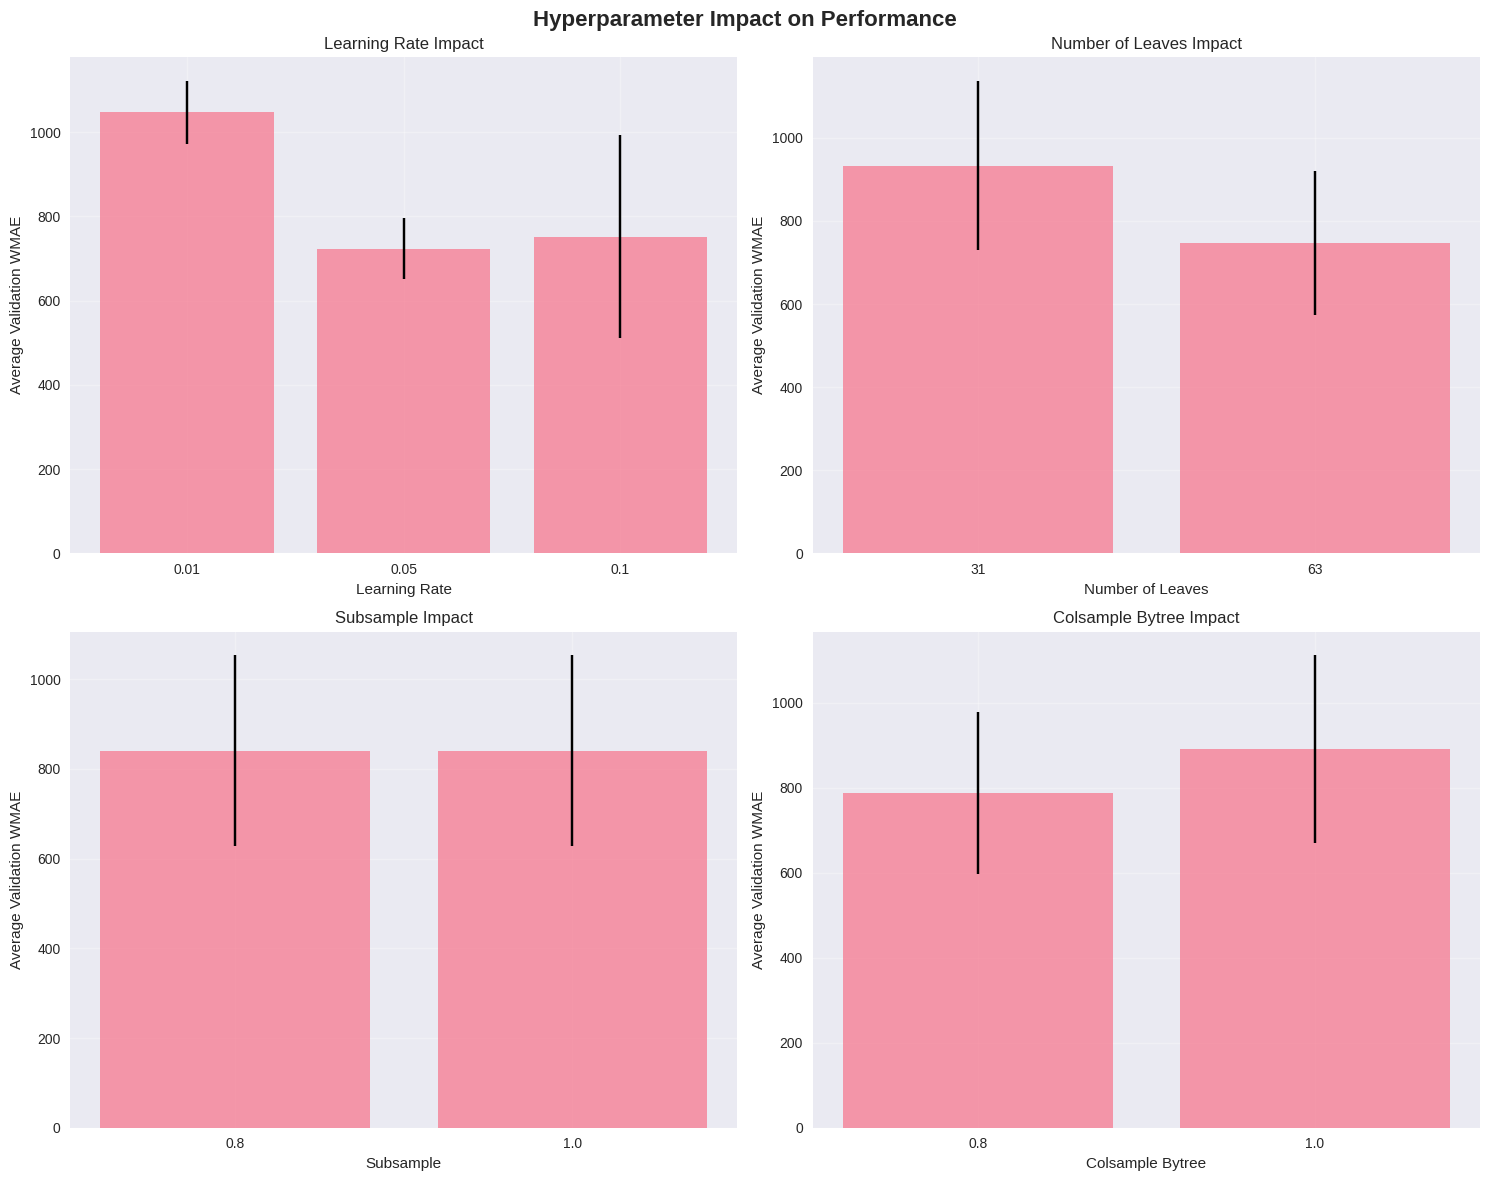


GRID SEARCH SUMMARY
Total combinations tested: 24
Best validation WMAE: 589.30842

Top 5 Combinations (by validation WMAE):
  21: Val=589.30842, Test=575.92619 (LR=0.1, Leaves=63.0, Subsample=0.8, Colsample=0.8)
  23: Val=589.30842, Test=575.92619 (LR=0.1, Leaves=63.0, Subsample=1.0, Colsample=0.8)
  22: Val=622.50967, Test=592.12650 (LR=0.1, Leaves=63.0, Subsample=0.8, Colsample=1.0)
  24: Val=622.50967, Test=592.12650 (LR=0.1, Leaves=63.0, Subsample=1.0, Colsample=1.0)
  14: Val=652.93435, Test=638.92385 (LR=0.05, Leaves=63.0, Subsample=0.8, Colsample=1.0)

Parameter Impact (average validation WMAE):

learning_rate:
  0.01: 1046.80436 ± 74.77353
  0.05: 722.84513 ± 72.32213
  0.1: 751.37370 ± 240.84065

num_leaves:
  31: 933.57413 ± 203.61290
  63: 747.10799 ± 173.70379

subsample:
  0.8: 840.34106 ± 212.83382
  1.0: 840.34106 ± 212.83382

colsample_bytree:
  0.8: 789.11496 ± 190.66975
  1.0: 891.56716 ± 220.26388

BEST MODEL RESULTS
Best Parameters:
  learning_rate: 0.1
  num_leave

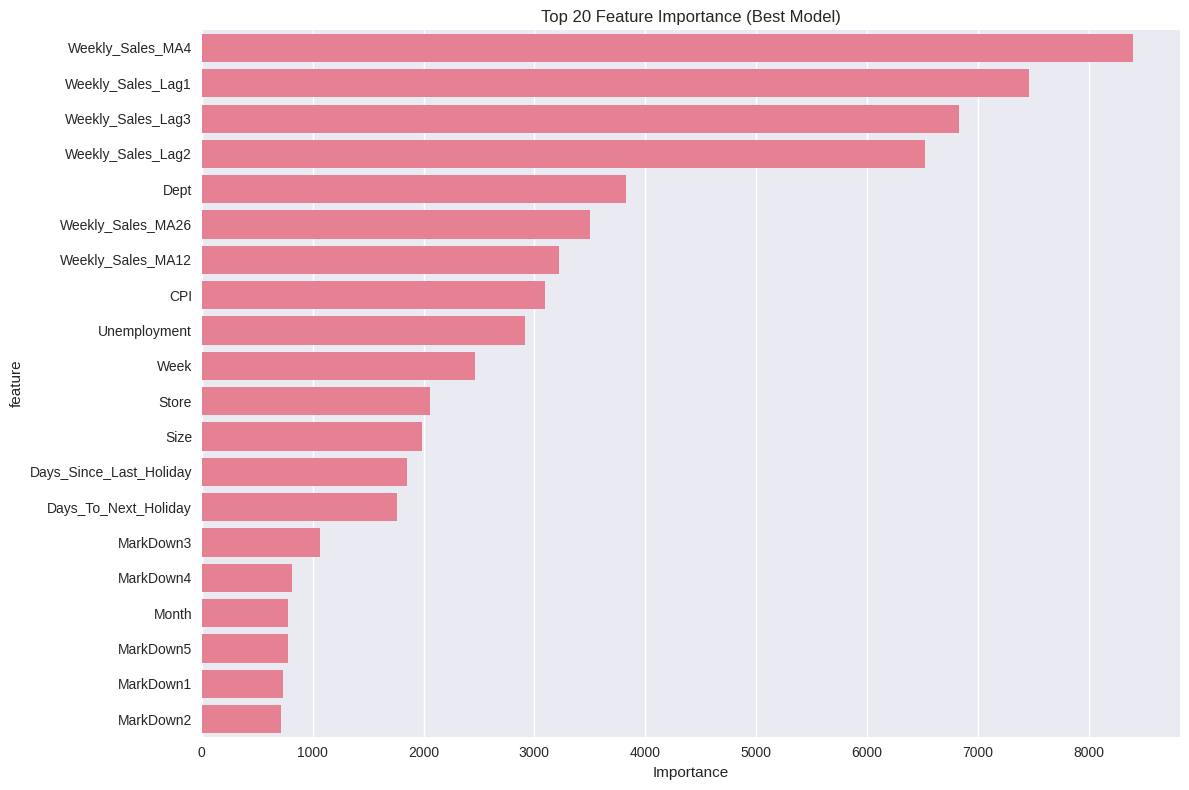

best_colsample_bytree,▁
best_learning_rate,▁
best_num_leaves,▁
best_subsample,▁
best_val_WMAE,▁
colsample_bytree,▁█▁█▁█▁█▁█▁█▁█▁█▁█▁█▁█▁█
final_test_WMAE,▁
learning_rate,▁▁▁▁▁▁▁▁▄▄▄▄▄▄▄▄████████
n_estimators_used,█▅█▅█▅█▅█████████▁█▁████
num_leaves,▁▁▁▁████▁▁▁▁████▁▁▁▁████
overfitting,▇█▇█▇▇▇▇▃▁▃▁▅▆▅▆▅█▅█▆▅▆▅



Grid search completed! Check your plots above and W&B dashboard for detailed analysis.


<Figure size 800x550 with 0 Axes>

In [15]:
import lightgbm as lgb
from lightgbm import early_stopping, log_evaluation
import numpy as np
import itertools
import wandb
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from collections import defaultdict
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

wandb.init(project="walmart-forecasting", name="GridSearch-WMAE")

# === Define hyperparameter grid ===
param_grid = {
    "learning_rate": [0.01, 0.05, 0.1],
    "num_leaves": [31, 63],
    "subsample": [0.8, 1.0],
    "colsample_bytree": [0.8, 1.0],
}

# Create combinations of all grid parameters
all_params = list(itertools.product(
    param_grid["learning_rate"],
    param_grid["num_leaves"],
    param_grid["subsample"],
    param_grid["colsample_bytree"]
))

# Tracking results
results = []
best_val_wmae = float("inf")
best_model = None
best_params = {}

print(f"Starting grid search with {len(all_params)} combinations...")

# === Grid Search ===
for i, (lr, leaves, subsample, colsample) in enumerate(all_params):
    print(f"\n[{i+1}/{len(all_params)}] Training with lr={lr}, leaves={leaves}, subsample={subsample}, colsample={colsample}")

    model = lgb.LGBMRegressor(
        objective="regression",
        learning_rate=lr,
        num_leaves=leaves,
        subsample=subsample,
        colsample_bytree=colsample,
        n_estimators=1000,
        random_state=42,
        verbosity=-1
    )

    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        eval_metric="mae",
        callbacks=[
            early_stopping(stopping_rounds=50),
            log_evaluation(period=0)
        ]
    )

    # Predict
    val_preds = model.predict(X_val)
    test_preds = model.predict(X_test)

    # Compute WMAE
    val_wmae = WMAE(y_val, val_preds, val_weights)
    test_wmae = WMAE(y_test, test_preds, test_weights)

    print(f"→ Val WMAE: {val_wmae:.5f}, Test WMAE: {test_wmae:.5f}")

    # Store results
    result = {
        "combination": i+1,
        "learning_rate": lr,
        "num_leaves": leaves,
        "subsample": subsample,
        "colsample_bytree": colsample,
        "val_WMAE": val_wmae,
        "test_WMAE": test_wmae,
        "n_estimators_used": model.best_iteration_ if hasattr(model, 'best_iteration_') else model.n_estimators,
        "overfitting": test_wmae - val_wmae
    }
    results.append(result)

    # Log to W&B
    wandb.log({
        "learning_rate": lr,
        "num_leaves": leaves,
        "subsample": subsample,
        "colsample_bytree": colsample,
        "val_WMAE": val_wmae,
        "test_WMAE": test_wmae,
        "overfitting": test_wmae - val_wmae,
        "n_estimators_used": result["n_estimators_used"]
    })

    # Track best
    if val_wmae < best_val_wmae:
        best_val_wmae = val_wmae
        best_model = model
        best_params = {
            "learning_rate": lr,
            "num_leaves": leaves,
            "subsample": subsample,
            "colsample_bytree": colsample
        }

# Convert results to DataFrame for easier plotting
df_results = pd.DataFrame(results)

# === VISUALIZATION SECTION ===

# 1. Performance Overview Plot
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Grid Search Results Overview', fontsize=16, fontweight='bold')

# Val vs Test WMAE scatter
axes[0, 0].scatter(df_results['val_WMAE'], df_results['test_WMAE'],
                   alpha=0.7, s=60, c=df_results['learning_rate'], cmap='viridis')
axes[0, 0].plot([df_results['val_WMAE'].min(), df_results['val_WMAE'].max()],
                [df_results['val_WMAE'].min(), df_results['val_WMAE'].max()],
                'r--', alpha=0.5)
axes[0, 0].set_xlabel('Validation WMAE')
axes[0, 0].set_ylabel('Test WMAE')
axes[0, 0].set_title('Validation vs Test WMAE')
axes[0, 0].grid(True, alpha=0.3)

# Performance by combination
axes[0, 1].plot(df_results['combination'], df_results['val_WMAE'],
                'o-', label='Validation WMAE', alpha=0.7)
axes[0, 1].plot(df_results['combination'], df_results['test_WMAE'],
                'o-', label='Test WMAE', alpha=0.7)
axes[0, 1].axhline(y=best_val_wmae, color='red', linestyle='--', alpha=0.5, label='Best Val WMAE')
axes[0, 1].set_xlabel('Combination #')
axes[0, 1].set_ylabel('WMAE')
axes[0, 1].set_title('Performance by Combination')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Overfitting analysis
axes[1, 0].scatter(df_results['val_WMAE'], df_results['overfitting'],
                   alpha=0.7, s=60, c=df_results['num_leaves'], cmap='plasma')
axes[1, 0].axhline(y=0, color='red', linestyle='--', alpha=0.5)
axes[1, 0].set_xlabel('Validation WMAE')
axes[1, 0].set_ylabel('Overfitting (Test - Val)')
axes[1, 0].set_title('Overfitting Analysis')
axes[1, 0].grid(True, alpha=0.3)

# Distribution of results
axes[1, 1].hist(df_results['val_WMAE'], bins=10, alpha=0.7, label='Validation WMAE')
axes[1, 1].hist(df_results['test_WMAE'], bins=10, alpha=0.7, label='Test WMAE')
axes[1, 1].axvline(x=best_val_wmae, color='red', linestyle='--', alpha=0.7, label='Best Val WMAE')
axes[1, 1].set_xlabel('WMAE')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title('WMAE Distribution')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 2. Hyperparameter Impact Analysis
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Hyperparameter Impact on Performance', fontsize=16, fontweight='bold')

# Learning rate impact
lr_grouped = df_results.groupby('learning_rate')['val_WMAE'].agg(['mean', 'std', 'min', 'max'])
axes[0, 0].bar(lr_grouped.index.astype(str), lr_grouped['mean'],
               yerr=lr_grouped['std'], capsize=5, alpha=0.7)
axes[0, 0].set_xlabel('Learning Rate')
axes[0, 0].set_ylabel('Average Validation WMAE')
axes[0, 0].set_title('Learning Rate Impact')
axes[0, 0].grid(True, alpha=0.3)

# Num leaves impact
leaves_grouped = df_results.groupby('num_leaves')['val_WMAE'].agg(['mean', 'std', 'min', 'max'])
axes[0, 1].bar(leaves_grouped.index.astype(str), leaves_grouped['mean'],
               yerr=leaves_grouped['std'], capsize=5, alpha=0.7)
axes[0, 1].set_xlabel('Number of Leaves')
axes[0, 1].set_ylabel('Average Validation WMAE')
axes[0, 1].set_title('Number of Leaves Impact')
axes[0, 1].grid(True, alpha=0.3)

# Subsample impact
subsample_grouped = df_results.groupby('subsample')['val_WMAE'].agg(['mean', 'std', 'min', 'max'])
axes[1, 0].bar(subsample_grouped.index.astype(str), subsample_grouped['mean'],
               yerr=subsample_grouped['std'], capsize=5, alpha=0.7)
axes[1, 0].set_xlabel('Subsample')
axes[1, 0].set_ylabel('Average Validation WMAE')
axes[1, 0].set_title('Subsample Impact')
axes[1, 0].grid(True, alpha=0.3)

# Colsample impact
colsample_grouped = df_results.groupby('colsample_bytree')['val_WMAE'].agg(['mean', 'std', 'min', 'max'])
axes[1, 1].bar(colsample_grouped.index.astype(str), colsample_grouped['mean'],
               yerr=colsample_grouped['std'], capsize=5, alpha=0.7)
axes[1, 1].set_xlabel('Colsample Bytree')
axes[1, 1].set_ylabel('Average Validation WMAE')
axes[1, 1].set_title('Colsample Bytree Impact')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 3. Interactive Plotly Visualization
fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=('Val vs Test WMAE', 'Performance Timeline',
                   'Hyperparameter Heatmap', 'Top 5 Combinations'),
    specs=[[{"secondary_y": False}, {"secondary_y": False}],
           [{"secondary_y": False}, {"secondary_y": False}]]
)

# Val vs Test scatter
fig.add_trace(
    go.Scatter(
        x=df_results['val_WMAE'],
        y=df_results['test_WMAE'],
        mode='markers',
        marker=dict(
            size=8,
            color=df_results['learning_rate'],
            colorscale='Viridis',
            showscale=True,
            colorbar=dict(title="Learning Rate")
        ),
        text=[f"Combo {i+1}<br>LR: {lr}<br>Leaves: {leaves}"
              for i, (lr, leaves) in enumerate(zip(df_results['learning_rate'], df_results['num_leaves']))],
        hovertemplate='<b>%{text}</b><br>Val WMAE: %{x:.5f}<br>Test WMAE: %{y:.5f}<extra></extra>',
        name='Combinations'
    ),
    row=1, col=1
)

# Performance timeline
fig.add_trace(
    go.Scatter(
        x=df_results['combination'],
        y=df_results['val_WMAE'],
        mode='lines+markers',
        name='Val WMAE',
        line=dict(color='blue')
    ),
    row=1, col=2
)

fig.add_trace(
    go.Scatter(
        x=df_results['combination'],
        y=df_results['test_WMAE'],
        mode='lines+markers',
        name='Test WMAE',
        line=dict(color='red')
    ),
    row=1, col=2
)

# Hyperparameter correlation heatmap
param_cols = ['learning_rate', 'num_leaves', 'subsample', 'colsample_bytree']
corr_matrix = df_results[param_cols + ['val_WMAE']].corr()

fig.add_trace(
    go.Heatmap(
        z=corr_matrix.values,
        x=corr_matrix.columns,
        y=corr_matrix.columns,
        colorscale='RdYlBu',
        zmid=0
    ),
    row=2, col=1
)

# Top 5 combinations
top_5 = df_results.nsmallest(5, 'val_WMAE')
fig.add_trace(
    go.Bar(
        x=[f"Combo {i}" for i in top_5['combination']],
        y=top_5['val_WMAE'],
        name='Top 5 Val WMAE',
        marker_color='lightblue'
    ),
    row=2, col=2
)

fig.update_layout(
    title_text="Interactive Grid Search Analysis",
    showlegend=False,
    height=800
)

fig.show()

# 4. Summary Statistics Table
print("\n" + "="*60)
print("GRID SEARCH SUMMARY")
print("="*60)

print(f"Total combinations tested: {len(all_params)}")
print(f"Best validation WMAE: {best_val_wmae:.5f}")

# Top 5 combinations
print("\nTop 5 Combinations (by validation WMAE):")
top_5 = df_results.nsmallest(5, 'val_WMAE')
for idx, row in top_5.iterrows():
    print(f"  {int(row['combination'])}: Val={row['val_WMAE']:.5f}, Test={row['test_WMAE']:.5f} "
          f"(LR={row['learning_rate']}, Leaves={row['num_leaves']}, "
          f"Subsample={row['subsample']}, Colsample={row['colsample_bytree']})")

# Parameter impact analysis
print("\nParameter Impact (average validation WMAE):")
for param in param_cols:
    print(f"\n{param}:")
    param_impact = df_results.groupby(param)['val_WMAE'].agg(['mean', 'std']).round(5)
    for val, stats in param_impact.iterrows():
        print(f"  {val}: {stats['mean']:.5f} ± {stats['std']:.5f}")

# === Final Report ===
print("\n" + "="*60)
print("BEST MODEL RESULTS")
print("="*60)

print("Best Parameters:")
for k, v in best_params.items():
    print(f"  {k}: {v}")

print(f"\nBest Validation WMAE: {best_val_wmae:.5f}")

# Final Test WMAE
final_test_preds = best_model.predict(X_test)
final_test_wmae = WMAE(y_test, final_test_preds, test_weights)
print(f"Final Test WMAE: {final_test_wmae:.5f}")
print(f"Overfitting (Test - Val): {final_test_wmae - best_val_wmae:.5f}")

# Feature importance plot for best model
if hasattr(best_model, 'feature_importances_'):
    feature_names = X_train.columns if hasattr(X_train, 'columns') else [f'feature_{i}' for i in range(X_train.shape[1])]
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False).head(20)

    plt.figure(figsize=(12, 8))
    sns.barplot(data=importance_df, x='importance', y='feature')
    plt.title('Top 20 Feature Importance (Best Model)')
    plt.xlabel('Importance')
    plt.tight_layout()
    plt.show()

# Log final results to wandb
wandb.log({
    "best_val_WMAE": best_val_wmae,
    "final_test_WMAE": final_test_wmae,
    "best_learning_rate": best_params["learning_rate"],
    "best_num_leaves": best_params["num_leaves"],
    "best_subsample": best_params["subsample"],
    "best_colsample_bytree": best_params["colsample_bytree"],
    "overfitting_best_model": final_test_wmae - best_val_wmae
})

# Log plots to wandb
wandb.log({
    "grid_search_overview": wandb.Image(plt.gcf()),
    "results_dataframe": wandb.Table(dataframe=df_results)
})

wandb.finish()

print("\nGrid search completed! Check your plots above and W&B dashboard for detailed analysis.")

In [ ]:
!pip install lightgbm --quiet
import lightgbm as lgb
import numpy as np
wandb.init(
    project="walmart-forecasting",
    entity="final-project-ml",
    name="lightGBM basic",
    config={
        "model": "LightGBM",
        "learning_rate": 0.05,
        "num_leaves": 31,
        "n_estimators": 1000,
        "subsample": 0.8,
        "colsample_bytree": 0.8,
        "random_state": 42
    }
)

In [ ]:
model = lgb.LGBMRegressor(
    objective="regression",
    learning_rate=0.05,
    num_leaves=31,
    n_estimators=1000,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    verbosity=-1
)

best_val_wmae = float("inf")
early_stopping_rounds = 50
rounds_no_improve = 0

for i in range(1, 101):
    model.n_estimators = i
    model.fit(X_train, y_train)

    train_preds = model.predict(X_train)
    val_preds = model.predict(X_val)
    test_preds = model.predict(X_test)

    train_wmae = WMAE(y_train, train_preds, train_weights)
    val_wmae = WMAE(y_val, val_preds, val_weights)
    test_wmae = WMAE(y_test, test_preds, test_weights)


    wandb.log({
        "epoch": i,
        "train_WMAE": train_wmae,
        "val_WMAE": val_wmae,
        "test_WMAE": test_wmae,
    })

    print(f"Epoch {i} - Train: {train_wmae:.2f}"
          f", Val: {val_wmae:.2f}"
          f", Test: {test_wmae:.2f}")

    if val_wmae < best_val_wmae:
        best_val_wmae = val_wmae
        rounds_no_improve = 0
    else:
        rounds_no_improve += 1

    if rounds_no_improve >= early_stopping_rounds:
        print(f"Early stopping at round {i}")
        break

wandb.finish()

Epoch 1 - Train: 14661.85 (89.98%), Val: 14474.29 (90.49%), Test: 14382.53 (91.43%)
Epoch 2 - Train: 13963.25 (85.69%), Val: 13766.05 (86.06%), Test: 13676.35 (86.94%)
Epoch 3 - Train: 13301.82 (81.63%), Val: 13092.38 (81.85%), Test: 13007.92 (82.69%)
Epoch 4 - Train: 12679.89 (77.82%), Val: 12451.16 (77.84%), Test: 12373.68 (78.66%)
Epoch 5 - Train: 12093.63 (74.22%), Val: 11840.16 (74.02%), Test: 11771.62 (74.83%)
Epoch 6 - Train: 11530.75 (70.77%), Val: 11263.97 (70.42%), Test: 11200.79 (71.20%)
Epoch 7 - Train: 11008.28 (67.56%), Val: 10717.45 (67.00%), Test: 10657.18 (67.75%)
Epoch 8 - Train: 10512.70 (64.52%), Val: 10201.11 (63.77%), Test: 10145.43 (64.49%)
Epoch 9 - Train: 10028.86 (61.55%), Val: 9709.15 (60.70%), Test: 9657.50 (61.39%)
Epoch 10 - Train: 9572.01 (58.74%), Val: 9242.33 (57.78%), Test: 9195.80 (58.46%)
Epoch 11 - Train: 9142.01 (56.11%), Val: 8798.64 (55.00%), Test: 8757.82 (55.67%)
Epoch 12 - Train: 8743.34 (53.66%), Val: 8379.66 (52.39%), Test: 8341.99 (53.03%)


epoch,▁▁▁▂▂▁▁▁▂▂▂▂▃▃▃▄▄▄▄▁▁▁▂▂▂▃▃▃▃▅▅▅▆▆▆▇▇▇██
test_WMAE,▇▆▆▆▆▇▇▆▆▅▄▃▃▂▂▁█▅▄▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_WMAE_percent,█▇▆▄▃▃▃▂▂▂▁▁█▇▆▆▃▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_WMAE,█▇▇▆█▆▆▅▅▄█▇▅▄▄▃▂▂▂▁▆▆▅▅▅▄▂▂▂▂▁▁▁▁▁▁▁▁▁▁
train_WMAE_percent,█▆▆▅▄▃▃▃▂▂▂▂▂▁█▆▅▅▅▄▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_WMAE,▆██▇▇▇▅▄▄█▅▄▄▃▃▂▂▂▁▁▅▅▄▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
val_WMAE_percent,██▇▅▅▄▄▄▄▂▂▂▂█▅▅▄▄▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,100
test_WMAE,1425.34185
test_WMAE_percent,9.06062
train_WMAE,1737.16161


In [ ]:
import lightgbm as lgb
import numpy as np
import pandas as pd
import itertools
import wandb

# Initialize wandb
wandb.init(
    project="walmart-forecasting",
    entity="final-project-ml",
    name="LightGBM tuning",
    config={
        "model": "LightGBM",
        "search_type": "grid",
        "early_stopping_rounds": 50,
        "n_estimators": 1000,
        "metric": "WMAE"
    }
)

# Define WMAE
def WMAE(y_true, y_pred, weights):
    return np.sum(weights * np.abs(y_true - y_pred)) / np.sum(weights)

# Define weights
train_weights = np.where(train_df['IsHoliday'] == True, 5, 1)
val_weights = np.where(val_df['IsHoliday'] == True, 5, 1)
test_weights = np.where(test_df['IsHoliday'] == True, 5, 1)

# Hyperparameter grid
param_grid = {
    'num_leaves': [31, 50, 70],
    'max_depth': [7, 10, 15],
    'learning_rate': [0.05, 0.1],
    'min_child_samples': [20, 50],
    'subsample': [0.8, 1.0]
}

best_val_wmae = float('inf')
best_params = None

# Grid search
for num_leaves, max_depth, learning_rate, min_child_samples, subsample in itertools.product(
    param_grid['num_leaves'],
    param_grid['max_depth'],
    param_grid['learning_rate'],
    param_grid['min_child_samples'],
    param_grid['subsample']
):
    model = lgb.LGBMRegressor(
        objective="regression",
        num_leaves=num_leaves,
        max_depth=max_depth,
        learning_rate=learning_rate,
        n_estimators=1000,
        min_child_samples=min_child_samples,
        subsample=subsample,
        random_state=42
    )

    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        callbacks=[lgb.early_stopping(stopping_rounds=50, verbose=False)]
    )

    val_preds = model.predict(X_val, num_iteration=model.best_iteration_)
    val_wmae = WMAE(y_val, val_preds, val_weights)

    wandb.log({
        "val_WMAE": val_wmae,
        "params/num_leaves": num_leaves,
        "params/max_depth": max_depth,
        "params/learning_rate": learning_rate,
        "params/min_child_samples": min_child_samples,
        "params/subsample": subsample
    })

    print(f"Params: num_leaves={num_leaves}, max_depth={max_depth}, lr={learning_rate}, "
          f"min_child_samples={min_child_samples}, subsample={subsample} -> Val WMAE: {val_wmae:.4f}")

    if val_wmae < best_val_wmae:
        best_val_wmae = val_wmae
        best_params = {
            'num_leaves': num_leaves,
            'max_depth': max_depth,
            'learning_rate': learning_rate,
            'min_child_samples': min_child_samples,
            'subsample': subsample
        }

# Final training on train+val
print("\nBest params:", best_params)
print("Best validation WMAE:", best_val_wmae)

X_train_val = pd.concat([X_train, X_val])
y_train_val = pd.concat([y_train, y_val])

final_model = lgb.LGBMRegressor(
    objective="regression",
    **best_params,
    n_estimators=1000,
    random_state=42
)

final_model.fit(
    X_train_val, y_train_val,
    eval_set=[(X_val, y_val)],
    callbacks=[lgb.early_stopping(stopping_rounds=50, verbose=False)]
)

test_preds = final_model.predict(X_test, num_iteration=final_model.best_iteration_)
test_wmae = WMAE(y_test, test_preds, test_weights)

print(f"Test WMAE with best params: {test_wmae:.4f}")
wandb.log({"final_test_WMAE": test_wmae})

wandb.finish()

Params: num_leaves=31, max_depth=7, lr=0.05, min_child_samples=20, subsample=0.8 -> Val WMAE: 875.1967
Params: num_leaves=31, max_depth=7, lr=0.05, min_child_samples=20, subsample=1.0 -> Val WMAE: 875.1967
Params: num_leaves=31, max_depth=7, lr=0.05, min_child_samples=50, subsample=0.8 -> Val WMAE: 901.4147
Params: num_leaves=31, max_depth=7, lr=0.05, min_child_samples=50, subsample=1.0 -> Val WMAE: 901.4147
Params: num_leaves=31, max_depth=7, lr=0.1, min_child_samples=20, subsample=0.8 -> Val WMAE: 730.5658
Params: num_leaves=31, max_depth=7, lr=0.1, min_child_samples=20, subsample=1.0 -> Val WMAE: 730.5658
Params: num_leaves=31, max_depth=7, lr=0.1, min_child_samples=50, subsample=0.8 -> Val WMAE: 726.7433
Params: num_leaves=31, max_depth=7, lr=0.1, min_child_samples=50, subsample=1.0 -> Val WMAE: 726.7433
Params: num_leaves=31, max_depth=10, lr=0.05, min_child_samples=20, subsample=0.8 -> Val WMAE: 871.2514
Params: num_leaves=31, max_depth=10, lr=0.05, min_child_samples=20, subsampl

final_test_WMAE,▁
params/learning_rate,▁▁███▁▁██▁▁██▁▁▁██▁▁██▁██▁▁▁███▁▁██▁▁▁██
params/max_depth,▁▁▁▁▄▄▄▄████▁▁▁▄▄▄▄▄█████▁▁▁▁▁▄▄▄▄▄█████
params/min_child_samples,▁▁██▁█▁█▁▁▁▁▁████▁▁███▁▁█▁▁█▁▁▁██▁▁▁██▁█
params/num_leaves,▁▁▁▁▁▁▁▁▁▁▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄███████████████
params/subsample,▁█▁██▁▁▁█▁▁▁█▁██▁█▁██▁█▁█▁██▁██▁█▁██▁█▁▁
val_WMAE,▇█▄▄▄██▅▅▅▇▃▅▅▅▅▂▂▄▅▅▂▂▂▂▄▂▂▄▄▂▄▅▄▁▂▃▃▃▁
final_test_WMAE,841.44964
params/learning_rate,0.1
params/max_depth,15
params/min_child_samples,50
